In [1]:
import h5py, sys, os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
from scipy import interpolate
from datetime import datetime
from os.path import join
print(os.getcwd())

%matplotlib ipympl

vapour = True

from jfunctions import *

base_dir = '/store/ATMOS/cwp29/data/moisture/'
dir = 'moist_exp'
simulations = ['q0_5_phis_001', 'q0_2_phis_002', 'q0_02_phis_003']
res = '512'

def hydration_profile(phibins, Wv):
    return phibins * np.nansum(Wv, axis=1)

/mhome/damtp/q/cwp29/diablo3/proc/jupyter/moisture


q0_5_phis_001
Plume penetration occured at t=4.2607
1.565890168740143e-08
q0_2_phis_002
Plume penetration occured at t=4.2463
3.159873374121525e-08
q0_02_phis_003
Plume penetration occured at t=4.2463
4.764406107987955e-08


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


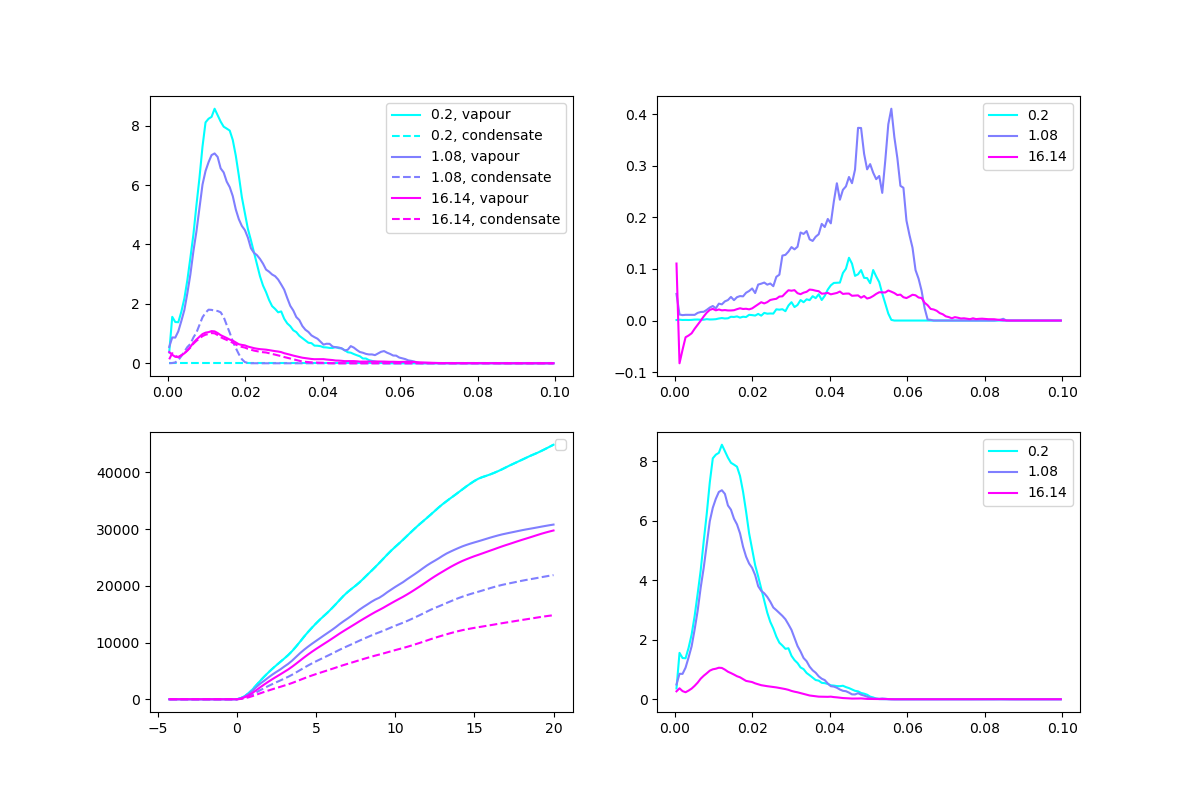

In [2]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
cols = plt.cm.cool(np.linspace(0,1,len(simulations)))

for d in range(len(simulations)):
    print(simulations[d])
    save_dir = join(base_dir, dir, simulations[d], res)
    
    # Load simulation metadata
    md = get_metadata(run_dir=save_dir, version="3.12")
    
    #Load simulation data
    Wv, Wc, Wp, Sv_cum, Sc_cum, Sp_cum, times = load_data('b_phiv_W', 'b_phic_W', 'b_phip_W', 'b_phiv_S', 'b_phic_S', 'b_phip_S', save_dir=save_dir, verbose=False)
    
    NSAMP = len(times)

    bbins, phivbins = load_bins_moist(save_dir, True, verbose=False)
    bbins, phicbins = load_bins_moist(save_dir, False, verbose=False)

    times, t0_idx = calibrate_time(save_dir, times)
    
    # Set-up
    Wv = np.where(Wv == 0, np.NaN, Wv)
    Wc = np.where(Wc == 0, np.NaN, Wc)
    Wp = np.where(Wp == 0, np.NaN, Wp)

    F0 = compute_F0(save_dir, md, tstart_ind = 2*4, verbose=False, zbot=0.7, ztop=0.95, plot=False, moist=False, tracer=True)
    # need to change zbot and ztop, to (more) accurately measure F0. Maybe use phi_p to measure this?
    print(F0)
    
    for i in range(1, NSAMP):
        Sc_cum[i] += Sc_cum[i-1]
        Sv_cum[i] += Sv_cum[i-1]
        Sp_cum[i] += Sp_cum[i-1]
        
    Sc_cum = np.where(Sc_cum == 0, np.NaN, Sc_cum)
    Sp_cum = np.where(Sp_cum == 0, np.NaN, Sp_cum)
    Sv_cum = np.where(Sv_cum == 0, np.NaN, Sv_cum)
    
    b_az, phiv_az, phic_az, phip_az = load_az_data('b_az', 'phiv_az', 'phic_az', 'phip_az', save_dir=save_dir, verbose=False)
    gxf, gyf, gzf, dzf = get_grid(md, save_dir=save_dir)
    
    z_pen = md['H']

    phip_postpen = phip_az[np.logical_and(times > 0, times < md['T']), :, :]
    b_postpen = b_az[np.logical_and(times > 0, times < md['T']), :, :]

    phip_pen = np.mean(phip_postpen[:, get_index(gzf, z_pen), 0])
    b_pen = np.mean(b_postpen[:, get_index(gzf, z_pen), 0])

    phi_vs_pen = md['q0']*np.exp(md['alpha']*(b_pen - md['beta']*z_pen))

    sat_param = phip_pen / phi_vs_pen

    hv = hydration_profile(phivbins, Wv)
    hc = hydration_profile(phivbins, Wc)
    hp = hydration_profile(phivbins, Wp)

    axs[0,0].plot(bbins, hv[-1]/F0, color=cols[d], label=str(round(sat_param,2))+", vapour")
    axs[0,0].plot(bbins, hc[-1]/F0, color=cols[d], linestyle='--', label=str(round(sat_param,2))+", condensate")
    
    axs[0,1].plot(bbins, (hv[-1] - hp[-1])/F0, color=cols[d], label=round(sat_param,2))
    
    axs[1,0].plot(times, np.nansum(Sv_cum, axis=(1,2))/F0 + np.nansum(Sc_cum, axis=(1,2))/F0, color=cols[d])
    axs[1,0].plot(times, np.nansum(Sp_cum, axis=(1,2))/F0, color=cols[d], linestyle='--')
    #axs[1,0].plot(times, np.nansum(Sc_cum, axis=(1,2)), color=cols[d], linestyle='--')
    
    axs[1,1].plot(bbins, hp[-1]/F0, color=cols[d], label=round(sat_param,2))

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

plt.show()